In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path="/content/drive/MyDrive/FYP/processed_data/punjab_features.parquet"
df=pd.read_parquet(path)
df.head()

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/FYP/processed_data/punjab_features.parquet'

### Combine all files into parquet


In [ ]:
import os
import glob
import re
import pandas as pd

# Path to punjab's daily data folder
file_path = "/content/drive/MyDrive/FYP/cleaned_data/Daily/daily_data_punjab/"

# Get all CSV file paths
csv_files = glob.glob(os.path.join(file_path, "*.csv"))

# Define optimized data types for memory efficiency
dtype_mapping = {
    "temperature_2m_max": "float32",
    "temperature_2m_min": "float32",
    "precipitation_sum": "float32",
    "wind_speed_10m_max": "float32",
    "wind_gusts_10m_max": "float32",
    "wind_direction_10m_dominant": "float32",
    "shortwave_radiation_sum": "float32",
    "et0_fao_evapotranspiration": "float32"
}

# List to store individual DataFrames
df_list = []

# Regex pattern to extract grid number (assumes "Grid_X" format in filename)
grid_pattern = re.compile(r"Grid_(\d+)")

# Read each CSV, extract grid ID, and append to the list
for file in csv_files:
    match = grid_pattern.search(file)
    if match:
        grid_id = int(match.group(1))  # Extract grid number
    else:
        print(f"Warning: Could not extract grid ID from {file}")
        continue  # Skip file if no grid ID found

    df = pd.read_csv(file, dtype=dtype_mapping, parse_dates=["date"])
    df["grid_id"] = grid_id  # Add grid ID column
    df_list.append(df)

# Concatenate all DataFrames
punjab_df = pd.concat(df_list, ignore_index=True)

# Sort by date and grid ID (to keep structure consistent)
punjab_df = punjab_df.sort_values(by=["grid_id", "date"]).reset_index(drop=True)

# Display basic info
print(punjab_df.info())
punjab_df.head()

# Save merged file for future use
output_path = "/content/drive/MyDrive/FYP/processed_data/punjab_merged.parquet"
punjab_df.to_parquet(output_path, engine="pyarrow", index=False)
print(f"Processed data saved at: {output_path}")



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11308040 entries, 0 to 11308039
Data columns (total 11 columns):
 #   Column                       Dtype              
---  ------                       -----              
 0   date                         datetime64[ns, UTC]
 1   temperature_2m_max           float32            
 2   temperature_2m_min           float32            
 3   temperature_2m_mean          float64            
 4   precipitation_sum            float32            
 5   wind_speed_10m_max           float32            
 6   wind_gusts_10m_max           float32            
 7   wind_direction_10m_dominant  float32            
 8   shortwave_radiation_sum      float32            
 9   et0_fao_evapotranspiration   float32            
 10  grid_id                      int64              
dtypes: datetime64[ns, UTC](1), float32(8), float64(1), int64(1)
memory usage: 603.9 MB
None
Processed data saved at: /content/drive/MyDrive/FYP/processed_data/punjab_merged.parquet


### Feature Engineering

In [ ]:
import pandas as pd

# Load the merged punjab dataset
punjab_df = pd.read_parquet("/content/drive/MyDrive/FYP/processed_data/punjab_merged.parquet")

# Ensure data is sorted before applying rolling calculations
punjab_df = punjab_df.sort_values(by=["grid_id", "date"]).reset_index(drop=True)

# Create date-based features
punjab_df["year"] = punjab_df["date"].dt.year
punjab_df["month"] = punjab_df["date"].dt.month
punjab_df["day"] = punjab_df["date"].dt.day
punjab_df["day_of_year"] = punjab_df["date"].dt.dayofyear
punjab_df["week_of_year"] = punjab_df["date"].dt.isocalendar().week
punjab_df["season"] = punjab_df["month"].map({12: "winter", 1: "winter", 2: "winter",
                                                         3: "spring", 4: "spring", 5: "spring",
                                                         6: "summer", 7: "summer", 8: "summer",
                                                         9: "fall", 10: "fall", 11: "fall"})

# Compute rolling averages
punjab_df["temp_7d_avg"] = punjab_df.groupby("grid_id")["temperature_2m_mean"].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
punjab_df["temp_14d_avg"] = punjab_df.groupby("grid_id")["temperature_2m_mean"].transform(lambda x: x.rolling(window=14, min_periods=1).mean())

# Compute heatwave threshold (90th percentile of past temperatures per grid)
heatwave_thresholds = punjab_df.groupby("grid_id")["temperature_2m_mean"].quantile(0.90).to_dict()
punjab_df["heatwave_threshold"] = punjab_df["grid_id"].map(heatwave_thresholds)

# Define binary heatwave labels
punjab_df["is_heatwave_day"] = (punjab_df["temperature_2m_mean"] > punjab_df["heatwave_threshold"]).astype(int)

# Apply consecutive heatwave labeling (3+ consecutive hot days)
punjab_df["heatwave_final"] = punjab_df.groupby("grid_id")["is_heatwave_day"].transform(lambda x: x.rolling(window=3, min_periods=1).sum() >= 3).astype(int)

# Save processed file
output_path = "/content/drive/MyDrive/FYP/processed_data/punjab_features.parquet"
punjab_df.to_parquet(output_path, engine="pyarrow", index=False)
print(f"Feature engineered data saved at: {output_path}")

# Drop unnecessary columns
punjab_df = punjab_df.drop(columns=["temperature_2m_max", "temperature_2m_min", "wind_gusts_10m_max"])

# Save the updated dataset
output_path = "/content/drive/MyDrive/FYP/processed_data/punjab_features.parquet"
punjab_df.to_parquet(output_path, engine="pyarrow", index=False)

print(f"Updated dataset saved at: {output_path}")

# Display summary
print(punjab_df.info())
punjab_df.tail()


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration,grid_id,year,month,day,day_of_year,week_of_year,season,temp_7d_avg,temp_14d_avg,heatwave_threshold,is_heatwave_day,heatwave_final
11308035,2024-12-26 19:00:00+00:00,11.515083,14.800001,12.982480,77.629486,4.56,0.915997,1239,2024,12,26,361,52,winter,11.457047,11.180410,30.618476,0,0
11308036,2024-12-27 19:00:00+00:00,12.292167,17.800001,12.860870,86.156807,7.24,1.145000,1239,2024,12,27,362,52,winter,11.681154,11.317910,30.618476,0,0
11308037,2024-12-28 19:00:00+00:00,11.040084,0.000000,9.243311,316.073425,10.67,1.649028,1239,2024,12,28,363,52,winter,11.617762,11.312702,30.618476,0,0
11308038,2024-12-29 19:00:00+00:00,10.160916,0.000000,6.439876,58.695805,9.43,1.383276,1239,2024,12,29,364,52,winter,11.521333,11.281750,30.618476,0,0
11308039,2024-12-30 19:00:00+00:00,10.100499,0.000000,8.227004,250.615494,9.40,1.385985,1239,2024,12,30,365,1,winter,11.250797,11.268506,30.618476,0,0


### EDA

In [1]:
print(punjab_df.info())  # Column types and non-null counts
  # Summary stats
print(punjab_df.isnull().sum())  # Missing values check
punjab_df.describe()

NameError: name 'punjab_df' is not defined

In [ ]:
# Count heatwave vs. non-heatwave days
heatwave_counts = punjab_df["heatwave_final"].value_counts()
print(heatwave_counts)
print()
print(punjab_df["is_heatwave_day"].value_counts(normalize=True))


heatwave_final
0    10621969
1      686071
Name: count, dtype: int64

is_heatwave_day
0    0.899989
1    0.100011
Name: proportion, dtype: float64


<ipython-input-9-c73920c0c599>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=monthly_heatwaves.index, y=monthly_heatwaves.values, palette="Reds")


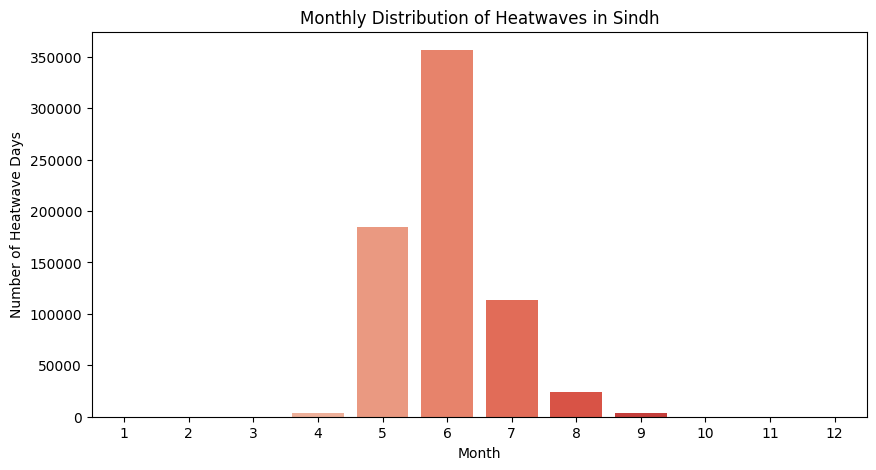

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count heatwave days per month
monthly_heatwaves = punjab_df.groupby("month")["heatwave_final"].sum()

plt.figure(figsize=(10, 5))
sns.barplot(x=monthly_heatwaves.index, y=monthly_heatwaves.values, palette="Reds")
plt.xlabel("Month")
plt.ylabel("Number of Heatwave Days")
plt.title("Monthly Distribution of Heatwaves in Sindh")
plt.show()


### Feature Correlation

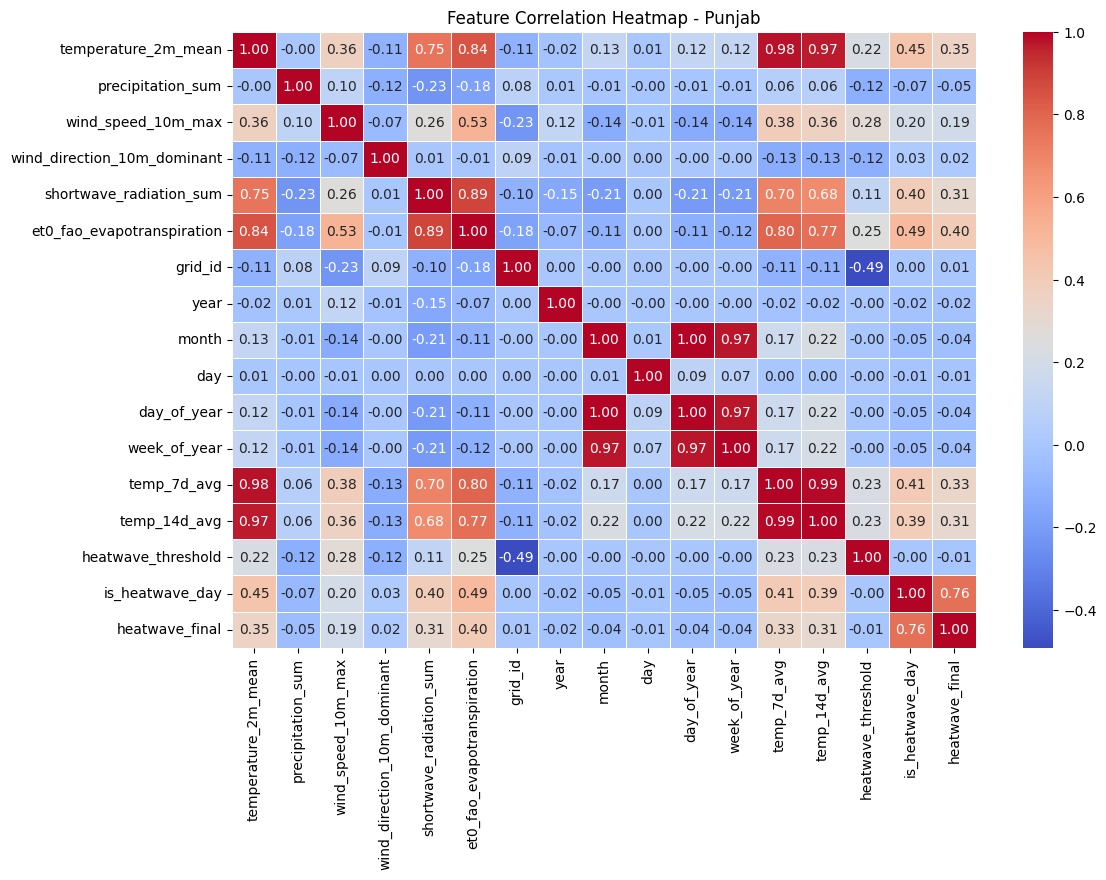

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numerical features
numeric_df = punjab_df.select_dtypes(include=['number'])

# Compute correlation matrix
correlation_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

plt.title("Feature Correlation Heatmap - Punjab")
plt.show()

## Model Training

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score, precision_recall_curve
from sklearn.pipeline import Pipeline
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

# Load punjab dataset
df = pd.read_parquet('/content/drive/MyDrive/FYP/processed_data/punjab_features.parquet')
df = df.dropna(subset=['et0_fao_evapotranspiration'])

def prepare_punjab_heatwave_data(df):
    if not pd.api.types.is_datetime64_any_dtype(df['date']):
        df['date'] = pd.to_datetime(df['date'])

    features = [
        'temperature_2m_mean', 'precipitation_sum',
        'wind_speed_10m_max', 'wind_direction_10m_dominant',
        'shortwave_radiation_sum', 'et0_fao_evapotranspiration',
        'month', 'day_of_year', 'season',
        'temp_7d_avg', 'temp_14d_avg',
        'heatwave_threshold'
    ]

    X = df[features]
    y = df['is_heatwave_day']
    return X, y, df['date']

def create_heatwave_pipeline():
    numeric_features = [
        'temperature_2m_mean', 'precipitation_sum',
        'wind_speed_10m_max', 'wind_direction_10m_dominant',
        'shortwave_radiation_sum', 'et0_fao_evapotranspiration',
        'day_of_year', 'temp_7d_avg', 'temp_14d_avg', 'heatwave_threshold'
    ]

    categorical_features = ['month', 'season']

    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', xgb.XGBClassifier(
            scale_pos_weight=9,  # Adjusted for 10% heatwave days (90/10 ≈ 9)
            n_estimators=100,
            learning_rate=0.1,
            random_state=42
        ))
    ])

    return pipeline

def evaluate_heatwave_model(pipeline, X_test, y_test):
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    avg_prec = average_precision_score(y_test, y_proba)
    print(f"\nAverage Precision Score: {avg_prec:.4f}")

    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5
    print(f"Optimal threshold: {optimal_threshold:.4f}")

    y_pred_optimal = (y_proba >= optimal_threshold).astype(int)
    print("\nClassification Report with Optimal Threshold:")
    print(classification_report(y_test, y_pred_optimal))

    return y_pred, y_proba, optimal_threshold

def feature_importance_analysis(pipeline, X):
    preprocessor = pipeline.named_steps['preprocessor']

    numeric_features = [
        'temperature_2m_mean', 'precipitation_sum',
        'wind_speed_10m_max', 'wind_direction_10m_dominant',
        'shortwave_radiation_sum', 'et0_fao_evapotranspiration',
        'day_of_year', 'temp_7d_avg', 'temp_14d_avg', 'heatwave_threshold'
    ]

    categorical_features = ['month', 'season']
    cat_encoder = preprocessor.named_transformers_['cat']
    cat_feature_names = list(cat_encoder.get_feature_names_out(categorical_features))
    feature_names = numeric_features + cat_feature_names

    classifier = pipeline.named_steps['classifier']
    importances = classifier.feature_importances_

    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)

    print("\nFeature Importances:")
    print(importance_df.head(10))

    return importance_df

def main(df):
    X, y, dates = prepare_punjab_heatwave_data(df)

    print("Class Distribution:")
    print(y.value_counts(normalize=True))

    split_idx = int(len(df) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    print(f"Training set size: {X_train.shape[0]} samples")
    print(f"Test set size: {X_test.shape[0]} samples")

    pipeline = create_heatwave_pipeline()
    pipeline.fit(X_train, y_train)

    y_pred, y_proba, optimal_threshold = evaluate_heatwave_model(pipeline, X_test, y_test)
    importance_df = feature_importance_analysis(pipeline, X)

    return pipeline, importance_df, optimal_threshold

# Run for punjab dataset
model, feature_importance, threshold = main(df)


Class Distribution:
is_heatwave_day
0    0.899989
1    0.100011
Name: proportion, dtype: float64
Training set size: 9046432 samples
Test set size: 2261608 samples

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00   2035463
           1       0.95      0.99      0.97    226145

    accuracy                           0.99   2261608
   macro avg       0.98      0.99      0.98   2261608
weighted avg       0.99      0.99      0.99   2261608


Confusion Matrix:
[[2024202   11261]
 [   1483  224662]]

Average Precision Score: 0.9979
Optimal threshold: 0.8895

Classification Report with Optimal Threshold:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   2035463
           1       0.99      0.98      0.99    226145

    accuracy                           1.00   2261608
   macro avg       0.99      0.99      0.99   2261608
weighted avg       1.00      1.00      1.00   2261

### Save the model

In [ ]:
import joblib

# Save the trained model
joblib.dump(model, "/content/drive/MyDrive/FYP/processed_data/heatwave_punjab_XGB.pkl")  # Update path if needed


['/content/drive/MyDrive/FYP/processed_data/heatwave_punjab_XGB.pkl']

### Verifying prediction from historical data
21-28 May 2024

In [ ]:
#import joblib
#model = joblib.load("/content/drive/MyDrive/FYP/processed_data/heatwave_sindh_XGB.pkl")

import pandas as pd

# Load dataset again (if needed)
df = pd.read_parquet('/content/drive/MyDrive/FYP/processed_data/punjab_features.parquet')
#df = df_karachi.dropna(subset=['et0_fao_evapotranspiration'])

df_lahore = df[df["grid_id"] == 1200 ]
#df=df_lahore
# Step 1: Sort by date
df_lahore = df_lahore.sort_values(by="date")

# Step 2: Compute rolling averages
#df["temp_7d_avg"] = df["temperature_2m_mean"].rolling(window=7, min_periods=1).mean()
#df["temp_14d_avg"] = df["temperature_2m_mean"].rolling(window=14, min_periods=1).mean()

# Step 3: Filter for June 18-24, 2024
df_june = df_lahore[(df_lahore["date"] >= "2024-05-01") & (df_lahore["date"] <= "2024-05-30")]

# Drop the target variable (if present)
X_new = df_june.drop(columns=["is_heatwave_day"], errors="ignore")

# Step 4: Apply the same preprocessing pipeline
X_new_transformed = model.named_steps["preprocessor"].transform(X_new)

# Step 5: Predict
predictions = model.named_steps["classifier"].predict(X_new_transformed)

# Step 6: Add predictions to DataFrame
df_june["predicted_heatwave"] = predictions

# Step 7: Show results
df_june[["date", "temperature_2m_mean", "predicted_heatwave"]]

<ipython-input-25-70f455f9a31e>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_june["predicted_heatwave"] = predictions


,date,temperature_2m_mean,predicted_heatwave
10951913,2024-05-01 19:00:00+00:00,25.566416,0
10951914,2024-05-02 19:00:00+00:00,27.589330,0
10951915,2024-05-03 19:00:00+00:00,28.789337,0
10951916,2024-05-04 19:00:00+00:00,29.768501,0
10951917,2024-05-05 19:00:00+00:00,30.356003,0
10951918,2024-05-06 19:00:00+00:00,31.578917,0
10951919,2024-05-07 19:00:00+00:00,31.874754,0
10951920,2024-05-08 19:00:00+00:00,32.195583,0
10951921,2024-05-09 19:00:00+00:00,31.112250,0
10951922,2024-05-10 19:00:00+00:00,29.643500,0


### Verifying from cleaned data

In [ ]:
import pandas as pd
import joblib

# Load trained model
model = joblib.load("/content/drive/MyDrive/FYP/processed_data/heatwave_punjab_XGB.pkl")

# Load Grid 4 data
file_path = "/content/drive/MyDrive/FYP/cleaned_data/Daily/daily_data_punjab/Grid_949_daily_punjab.csv"
df = pd.read_csv(file_path, parse_dates=['date'])

# Sort by date
df = df.sort_values(by="date")

df["temp_7d_avg"] = df["temperature_2m_mean"].rolling(window=7, min_periods=1).mean()
df["temp_14d_avg"] = df["temperature_2m_mean"].rolling(window=14, min_periods=1).mean()

# Drop rows where 'et0_fao_evapotranspiration' is missing
#df = df.dropna(subset=['et0_fao_evapotranspiration'])

# Feature Engineering: Add Missing Features
df["month"] = df["date"].dt.month
df["day_of_year"] = df["date"].dt.dayofyear

# Map seasons (based on your previous work)
def get_season(month):
    if month in [12, 1, 2]: return "Winter"
    elif month in [3, 4, 5]: return "Spring"
    elif month in [6, 7, 8]: return "Summer"
    else: return "Autumn"

df["season"] = df["month"].apply(get_season)

# Load Sindh-wide dataset to get original heatwave threshold
#punjab_df = pd.read_parquet('/content/drive/MyDrive/FYP/processed_data/punjab_features.parquet')

# Get the heatwave threshold used in training
global_heatwave_threshold = np.percentile(df["temperature_2m_mean"], 90)
#global_heatwave_threshold=punjab_df["heatwave_threshold"].unique()[0]

# Apply this fixed threshold to Grid 4
df["heatwave_threshold"] = global_heatwave_threshold

#df["heatwave_threshold"] = df["temperature_2m_max"].quantile(0.95)
# Filter for June 18-24, 2024
df_filtered = df[(df["date"] >= "2013-05-20") & (df["date"] <= "2013-05-30")]

# Drop target variable if present
X_new = df_filtered.drop(columns=["is_heatwave_day"], errors="ignore")

# Apply preprocessing pipeline
X_new_transformed = model.named_steps["preprocessor"].transform(X_new)

# Predict heatwave occurrence
predictions = model.named_steps["classifier"].predict(X_new_transformed)

# Store predictions in DataFrame
df_filtered["predicted_heatwave"] = predictions

# Show results
print(df_filtered[["date", "temperature_2m_mean", "predicted_heatwave"]])



                          date  temperature_2m_mean  predicted_heatwave
4886 2013-05-20 19:00:00+00:00            32.446083                   1
4887 2013-05-21 19:00:00+00:00            32.991913                   1
4888 2013-05-22 19:00:00+00:00            33.158580                   1
4889 2013-05-23 19:00:00+00:00            33.796085                   1
4890 2013-05-24 19:00:00+00:00            32.904415                   1
4891 2013-05-25 19:00:00+00:00            28.512750                   0
4892 2013-05-26 19:00:00+00:00            28.221085                   0
4893 2013-05-27 19:00:00+00:00            27.708582                   0
4894 2013-05-28 19:00:00+00:00            27.402330                   0
4895 2013-05-29 19:00:00+00:00            28.425250                   0


<ipython-input-15-766e1e9740b0>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["predicted_heatwave"] = predictions


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

feature_importance = model.named_steps["classifier"].feature_importances_
feature_names = model.named_steps["preprocessor"].get_feature_names_out()

# Create a DataFrame and sort by importance
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importance})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 5))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.gca().invert_yaxis()  # Highest importance at the top
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.show()


,Feature,Importance
0,num__temperature_2m_mean,0.716572
9,num__heatwave_threshold,0.170078
5,num__et0_fao_evapotranspiration,0.070905
24,cat__season_summer,0.023096
6,num__day_of_year,0.007026
15,cat__month_6,0.006698
8,num__temp_14d_avg,0.002790
4,num__shortwave_radiation_sum,0.000984
2,num__wind_speed_10m_max,0.000859
1,num__precipitation_sum,0.000281


SHAP analysis

In [ ]:
import shap
import joblib

# Load the trained model
model = joblib.load("/content/drive/MyDrive/FYP/processed_data/heatwave_punjab_XGB.pkl")

# Extract the XGBoost classifier from the pipeline
xgb_model = model.named_steps["classifier"]

# Load Grid 4 data
file_path = "/content/drive/MyDrive/FYP/cleaned_data/Daily/daily_data_punjab/Grid_1200_daily_punjab.csv"
df = pd.read_csv(file_path, parse_dates=['date'])

# Sort by date
df = df.sort_values(by="date")

df["temp_7d_avg"] = df["temperature_2m_mean"].rolling(window=7, min_periods=1).mean()
df["temp_14d_avg"] = df["temperature_2m_mean"].rolling(window=14, min_periods=1).mean()

# Drop rows where 'et0_fao_evapotranspiration' is missing
#df = df.dropna(subset=['et0_fao_evapotranspiration'])

# Feature Engineering: Add Missing Features
df["month"] = df["date"].dt.month
df["day_of_year"] = df["date"].dt.dayofyear

# Map seasons (based on your previous work)
def get_season(month):
    if month in [12, 1, 2]: return "Winter"
    elif month in [3, 4, 5]: return "Spring"
    elif month in [6, 7, 8]: return "Summer"
    else: return "Autumn"

df["season"] = df["month"].apply(get_season)

# Load Sindh-wide dataset to get original heatwave threshold
punjab_df = pd.read_parquet('/content/drive/MyDrive/FYP/processed_data/punjab_features.parquet')

# Get the heatwave threshold used in training
global_heatwave_threshold = punjab_df["heatwave_threshold"].unique()[0]

# Apply this fixed threshold to Grid 4
df["heatwave_threshold"] = global_heatwave_threshold

# Apply preprocessing from the pipeline
X_test_transformed = model.named_steps["preprocessor"].transform(df)

# Convert to DataFrame if necessary (XGBoost prefers DataFrames)
import pandas as pd
X_test_transformed = pd.DataFrame(X_test_transformed, columns=model.named_steps["preprocessor"].get_feature_names_out())

# Initialize SHAP explainer
explainer = shap.TreeExplainer(xgb_model)

# Compute SHAP values
shap_values = explainer.shap_values(X_test_transformed)

# Plot SHAP summary
shap.summary_plot(shap_values, X_test_transformed)


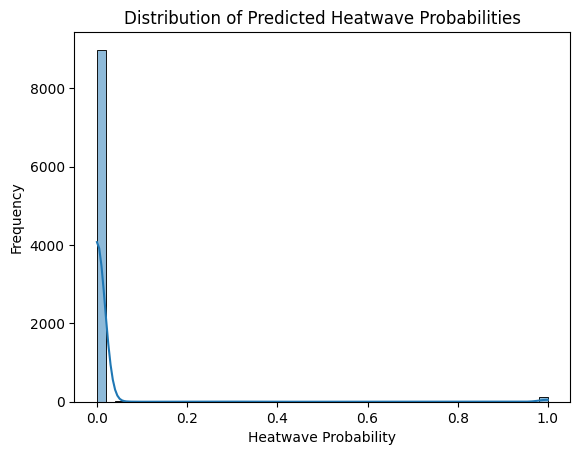

[2.1194102e-05 2.2080476e-05 2.2080476e-05 2.2080476e-05 2.1447791e-05
 2.1447791e-05 2.1447791e-05 2.2080476e-05 2.1447791e-05 2.2080476e-05
 2.0882326e-05 2.0882326e-05 2.1447791e-05 2.1447791e-05 2.1447791e-05
 2.1447791e-05 2.1447791e-05 2.1447791e-05 2.1447791e-05 2.1447791e-05]


In [ ]:
# Predict probabilities instead of labels
probs = model.predict_proba(df)[:, 1]  # Probability of heatwave (class 1)

# Check the distribution of probabilities
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(probs, bins=50, kde=True)
plt.xlabel("Heatwave Probability")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Heatwave Probabilities")
plt.show()

# Print some sample probabilities
print(probs[:20])  # First 20 predictions


In [ ]:
print("Training Data Temperature Distribution:")
print(df_lahore["temperature_2m_mean"].describe())

print("\nReal Data Temperature Distribution:")
print(df["temperature_2m_mean"].describe())

df[df["temperature_2m_mean"] > 36]

high_temp_data = df[df["temperature_2m_mean"] > 36]
high_temp_probs = model.predict_proba(high_temp_data)[:, 1]  # Get heatwave probabilities

print("Heatwave Probabilities for High Temp Cases:")
print(high_temp_probs)
print("Number of heatwaves predicted:", sum(high_temp_probs > 0.5))  # Using default 0.5 threshold

missed_cases = high_temp_data[high_temp_probs <= 0.5]
missed_probs = high_temp_probs[high_temp_probs <= 0.5]

print("Missed Heatwave Probabilities:")
print(missed_probs)

shap_values_missed = explainer(missed_cases)
shap.plots.waterfall(shap_values_missed[0])  # Look at the first missed case

print((df["temperature_2m_mean"] > 36).sum())  # Fixed threshold
print((df["temperature_2m_mean"] > np.percentile(df["temperature_2m_mean"], 90)).sum())  # Adaptive threshold


133
913
